In [198]:
import os
import pickle
import sys

sys.path.append(sys.path[0] + "/../..")  # Adds higher directory to python modules path.

import math
import numpy as np
import scipy
from Functions import renormalize, scomplex, plotting, support
import matplotlib.pyplot as plt
from scipy.stats import entropy as sp_entropy
import networkx as nx
import sklearn
from sklearn import cluster
import seaborn as sns
import powerlaw as pwl
plt.rcParams["text.usetex"] = True

import matplotlib.colors as mcolors
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage

from matplotlib.colors import LinearSegmentedColormap

#colors = list(mcolors.CSS4_COLORS)
#colors = colors + colors
colors = ["#071C56","#06418F","#2B589F","#5A5389","#7F588D","#533262","#B45389","#D75F78","#FDA599","#A40237"]
colors = colors + colors + colors + colors 
cmap = LinearSegmentedColormap.from_list("my_sas",colors)


In [158]:
# Triangle Tree
edges = [(0,1),(1,2),(0,2)]
new_boundary = [0,1,2]
n = 3
steps =5
for s in range(steps):
    boundary = new_boundary
    new_boundary = []
    for node in boundary:
        new_boundary.append(n)
        new_boundary.append(n+1)
        edges.append((node,n))
        edges.append((node,n+1))
        edges.append((n,n+1))
        n += 2
G = nx.from_edgelist(edges)

In [61]:
# Pseudofractal (2,1)
edges = [(0,1),(1,2),(0,2)]
n = 3
steps = 6
for s in range(steps):
    boundary = edges.copy()
    for ed in boundary:
        edges.append((ed[0],n))
        edges.append((ed[1],n))
        n += 1

G = nx.from_edgelist(edges)


In [85]:
# Pseudofractal (2,0)
nodes = [0,1,2]
edges = [(0,1),(1,2),(0,2)]
n = 3
steps =6 
for s in range(steps):
    boundary = nodes.copy()
    for node in boundary:
        edges.append((node,n))
        edges.append((node,n+1))
        edges.append((n,n+1))
        nodes.append(n)
        nodes.append(n+1)
        n += 2

G = nx.from_edgelist(edges)


In [166]:
# Pseudofractal mixed
nodes = [0,1,2]
edges = [(0,1),(1,2),(0,2)]
n = 3
steps =7
for s in range(steps):
    if np.mod(s,2) == 0:
        boundary = nodes.copy()
        for node in boundary:
            edges.append((node,n))
            edges.append((node,n+1))
            edges.append((n,n+1))
            nodes.append(n)
            nodes.append(n+1)
            n += 2
    else:
        boundary = edges.copy()
        for ed in boundary:
            edges.append((ed[0],n))
            edges.append((ed[1],n))
            nodes.append(n)
            n += 1

G = nx.from_edgelist(edges)


In [120]:
# Triangle Tree 2
edges = [(0,1),(1,2),(0,2)]
new_boundary = edges.copy()
n = 3
steps =9
for s in range(steps):
    boundary = new_boundary
    new_boundary = []
    for ed in boundary:
        edges.append((ed[0],n))
        edges.append((ed[1],n))
        new_boundary.append((ed[0],n))
        new_boundary.append((ed[1],n))
        n += 1

G = nx.from_edgelist(edges)
sc = scomplex.convert_graph_to_sc(G,dim = 3)


In [199]:
# C. Elegans
f = open("../../Data/dimacs10-celegans_metabolic/out.dimacs10-celegans_metabolic","r")
i = 0
edges = []
for line in f:
    if i != 0:
        words = line.split()
        edges.append((words[0],words[1]))
    else:
        i += 1
f.close()
G = nx.from_edgelist(edges)
G = nx.convert_node_labels_to_integers(G)
G.remove_edges_from(nx.selfloop_edges(G))
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G = G.subgraph(Gcc[0])

In [193]:
G2 = nx.configuration_model(list(dict(nx.degree(G)).values()))
G2 = nx.Graph(G2)
G2.remove_edges_from(nx.selfloop_edges(G2))

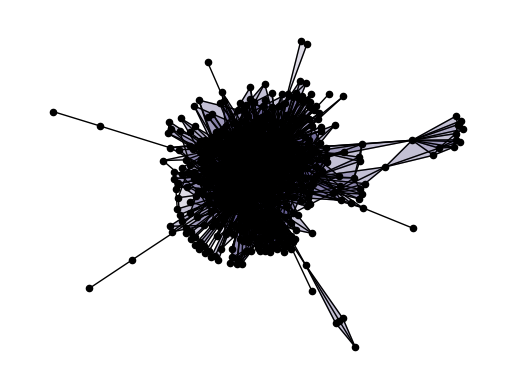

In [201]:

#G = nx.dorogovtsev_goltsev_mendes_graph(4)
#G = nx.random_tree(200, seed=10)
#G = nx.stochastic_block_model([40,40],[[0.3,0.02],[0.02,0.3]])

#G = nx.from_edgelist(edges)
sc = scomplex.convert_graph_to_sc(G,dim = 2)

#sc  = scomplex.generate_fractal_cycle([20,40,60,5],0.0,20)
#sc = scomplex.generate_tlattice(35,35,0)
#sc = scomplex.NGF(2,90,-1,0.1,2)
#sc = scomplex.generate_bridged_communities(50,50,0.04,0.04,10)

f,ax = plt.subplots(1,1)
plotting.plot_complex(sc,ax = ax,face_color=[colors[3]],layout = "spring", node_size=20)


In [204]:
laplacians_types = ["01u","02u","11d","11u","21d","22d"]
Laplacians = []
for l in laplacians_types:
    if l[2] == "u":
        arr = "up"
    else:
        arr = "down"
    L = scomplex.diffusion_laplacian(sc, k=int(l[0]), l=int(l[1]), arrow = arr)
    Laplacians.append(L)


eigs = []
sp_heats = []
for i in range(len(Laplacians)):
    L = Laplacians[i]
    D,U = np.linalg.eigh(L)
    specific_heat,tau_space, __ = renormalize.compute_heat(D,-3,4,200)
    sp_heats.append(specific_heat)
    eigs.append(D)

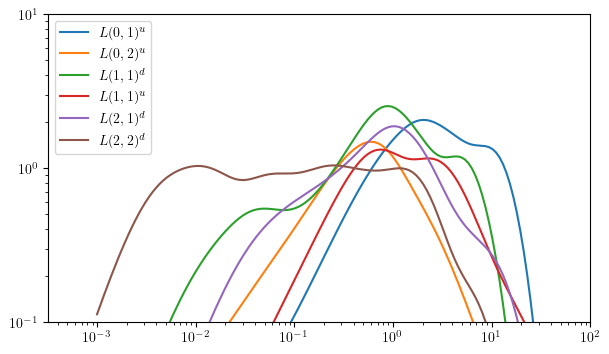

In [205]:
names = [f"$L({int(l[0])},{int(l[1])})^{l[2]}$" for l in laplacians_types]
f,ax = plt.subplots(1,1,figsize = (7,4))
for i in range(len(Laplacians)):
    ax.loglog(tau_space,sp_heats[i])
ax.set_ylim([10**-1,10])
ax.set_xlim([10**-3.5,10**2])
ax.legend(names)
#plt.savefig('CElegans_configurationModel_curves.png')

In [207]:
def renormalize_steps(sc,lmax,tau, order =1, PLOT = False, VERBOSE = False):
    #B1n, B2n, __, __, edge_dict, face_dict, tet_dict = scomplex.boundary_matrices_3(sc)
    if PLOT:
        fig,axs = plt.subplots(1,lmax,figsize = (18/4*lmax,4.4))

    sequence = []
    new_sc = sc
    for l in range(lmax):
        if l > 0 and new_sc["n0"]>1:
            if order == 0:
                L1new = (B1n@B1n.T).todense()
                #L1new = (0*scomplex.laplacian_of_order(new_sc, 1) +  scomplex.laplacian_of_order(new_sc, 2)).todense()
                #L1new = np.array((L1new - np.diag(np.diag(L1new))) != 0,dtype = int) 
                #L1new = L1new + np.diag(np.sum(np.abs(L1new),0))
            elif order == 1:
                #L1new = (B1n.T@B1n).todense()
                #L1new = (B2n@B2n.T).todense()
                #L1new = (B1n.T@B1n + B2n@B2n.T).todense()
                L1new = -np.abs(L1new - np.diag(np.diag(L1new))) + np.diag(np.array(np.sum(np.abs(L1new - np.diag(np.diag(L1new))),0))[0])
            elif order == 2:
                L1new = scomplex.diffusion_laplacian(new_sc, k=2, l=2, arrow = "down")

            D1new,U1new = np.linalg.eigh(L1new)

            rho  = np.abs(U1new@np.diag(np.exp(-tau*D1new))@U1new.T)
            Gv = nx.Graph()
            Gv.add_nodes_from([i for i in range(new_sc[f"n{order}"])])
            for i in range(new_sc[f"n{order}"]):
                for j in range(i+1,new_sc[f"n{order}"]):
                    if rho[i,j] >= min(rho[i,i],rho[j,j]):
                        Gv.add_edge(i,j)

                
            idx_components = {u:i for i,node_set in enumerate(nx.connected_components(Gv)) for u in node_set}
            clusters = [idx_components[u] for u in Gv.nodes]

            mapnodes,__ = renormalize.coarse_grain_interfaces(new_sc,order,clusters,np.max(clusters)+1)
            new_sc = renormalize.induce_simplices(new_sc, mapnodes)
        if VERBOSE:
            print(new_sc["n0"])
        if PLOT:
            #fcolors = []
            #for i in range(new_sc["n2"]):
            #    fcolors.append(colors[1*int(np.floor(math.log(new_sc["faces"][i,2]*2/3-1,3)))+7])

            plotting.plot_complex(new_sc,ax = axs[l], face_color=[colors[2*l]],edge_color=[0.4/255*np.array(tuple(int(colors[2*l].lstrip("#")[j:j+2], 16) for j in (0, 2, 4)))], node_color=[0.4/255*np.array(tuple(int(colors[2*l].lstrip("#")[j:j+2], 16) for j in (0, 2, 4)))],layout = "spring", iterations = 3000, node_size=4,edge_width=0.8,face_alpha = 0.4)
            #plotting.plot_complex(new_sc,ax = axs[l], face_color=fcolors,layout = "spring", node_size=4,edge_width=0.4+0.2*l,face_alpha = 0.45)
        sequence.append(new_sc)
    if PLOT:
        plt.tight_layout()
        #plt.savefig('pseudofractal_steps_pI.pdf')
        
    return sequence  

453
409
399
399


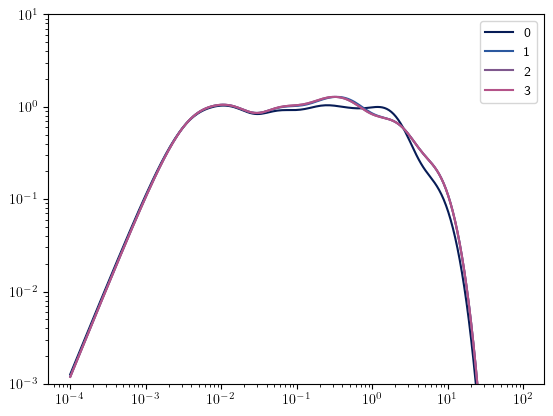

In [216]:
lmax = 4
sequence = renormalize_steps(sc,lmax,tau = 0.0078, order =2, PLOT = False, VERBOSE = True)
for i in range(lmax):
    scc = sequence[i]
    #B1n, B2n, __, __, edge_dict, face_dict, tet_dict = scomplex.boundary_matrices_3(scc)
    #L1new = (B2n.T@B2n).todense()
    #L1new = -np.abs(L1new - np.diag(np.diag(L1new))) + np.diag(np.array(np.sum(np.abs(L1new - np.diag(np.diag(L1new))),0))[0])
    #L1new = scomplex.laplacian_of_order(scc, 1).todense()
    #L1new = (B1n@B1n.T).todense()
    L1new = scomplex.diffusion_laplacian(scc, 2, 2, arrow = "down")

    D1new,U1new = np.linalg.eigh(L1new)
    specific_heat1,tau_space, __ = renormalize.compute_heat(D1new,-4,2,200)
    #pwl.plot_pdf(D1new[D1new>0])
    plt.loglog(tau_space,specific_heat1,color = colors[2*i])
plt.ylim([10**-3,10**1])
#plt.xlim([10**-1,10**2])
plt.legend([i for i in range(lmax)])

array([ 0.00283554,  0.00283554, -0.00222222, -0.00340136])

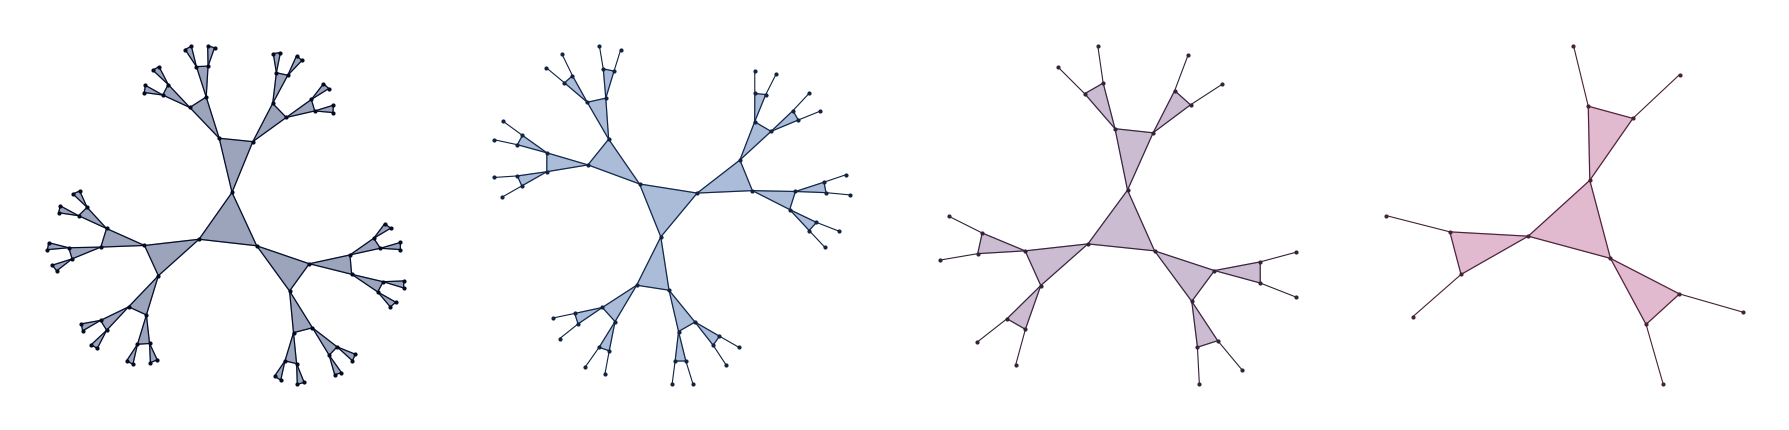

In [41]:
renormalize_steps(sc,4,tau = 1, order =1,PLOT = True)

array([0.00283554, 0.00283554, 0.00688705, 0.02      ])

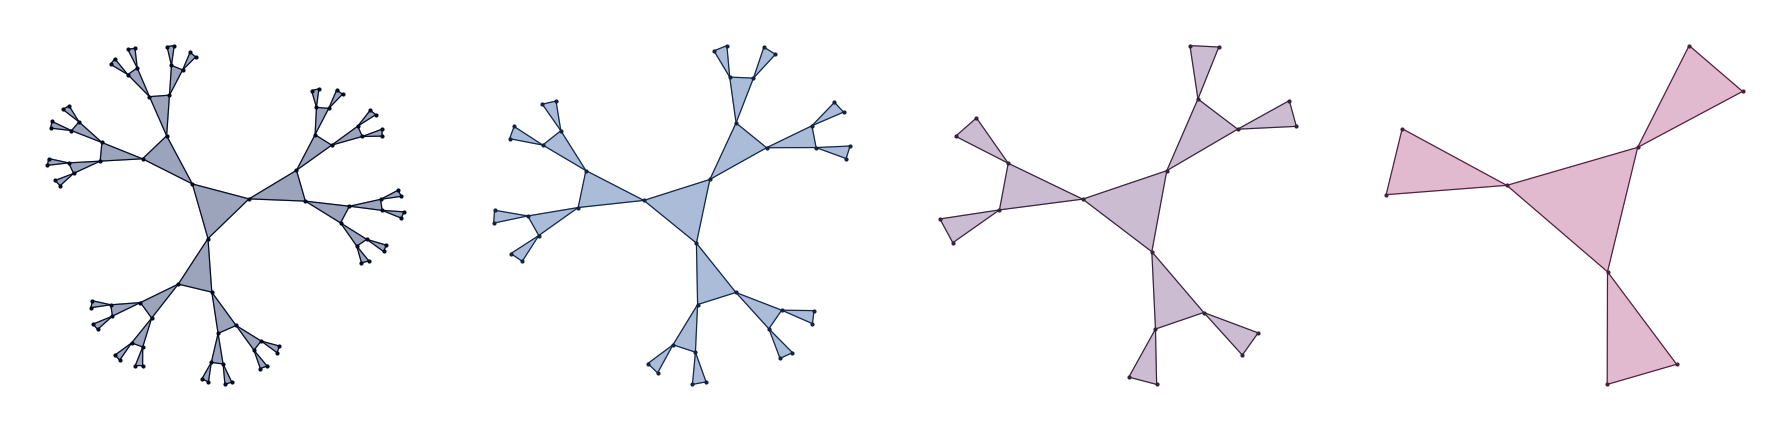

In [46]:
renormalize_steps(sc,4,tau = 1, order =0,PLOT = True)